In [1]:
import spotiphy
import squidpy as sq
import scanpy as sc
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib

In [2]:
results_folder = 'results/221_merge/Segmentation/'
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
img = sq.im.ImageContainer('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
Segmentation = spotiphy.segmentation.Segmentation(img['image'][:, :, 0], adata_st.obsm['spatial'], out_dir=results_folder, prob_thresh=0.1)
Segmentation.segment_nucleus(save=True)
n_cell_df = Segmentation.n_cell_df

Image.py (3176): Image size (99010000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.


Suppress the output of tensorflow prediction for tensorflow version 2.12.0>=2.9.0.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


100%|██████████| 64/64 [01:17<00:00,  1.21s/it]


In [13]:
nuclei_location = Segmentation.nucleus_center
nuclei_location = nuclei_location[:, [1, 0]]  # make it align with the image
nuclei_boundaries = Segmentation.nucleus_boundary
img_seg = Segmentation.label

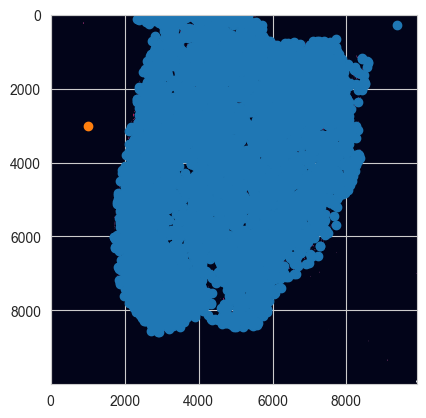

In [14]:
plt.scatter(nuclei_location[::10, 1], nuclei_location[::10, 0])
plt.scatter(1000, 3000)
plt.scatter(9900, 9900, c='white', s=1)
plt.imshow(img_seg)

In [15]:
nuclei_pixel_dict = {}
for i in range(len(img_seg)):
    for j in range(len(img_seg[0])):
        k = img_seg[i, j]
        if k > 0:
            if k in nuclei_pixel_dict.keys():
                nuclei_pixel_dict[k].append([i, j])
            else:
                nuclei_pixel_dict[k] = [[i, j]]

In [16]:
n_nuclei = np.max(img_seg)
size = np.zeros(n_nuclei+1)
max_area = 580
nuclei_left = set()
for i in range(1, n_nuclei+1):
    if i in nuclei_pixel_dict.keys():
        size[i] = len(nuclei_pixel_dict[i])
        if size[i] < max_area:
            nuclei_left.add(i)

In [17]:
for key in nuclei_pixel_dict.keys():
    nuclei_pixel_dict[key] = np.array(nuclei_pixel_dict[key])

In [18]:
%%time
radius = 0
while nuclei_left and radius<25:
    radius += 1
    print('r: '+str(radius))
    print(str(len(nuclei_left)) + ' nuclei left')
    nuclei_remove = set()
    for i in nuclei_left:
        x0, y0 = nuclei_pixel_dict[i][0]
        border_temp = []
        c_x = int(nuclei_location[i-1, 0])
        c_y = int(nuclei_location[i-1, 1])
        for dx in range(-radius-1, radius+2):
            for dy in range(-radius-1, radius+2):
                x1 = c_x + dx
                y1 = c_y + dy
                if 0<=x1<=img_seg.shape[0]-1 and 0<=y1<=img_seg.shape[1]-1 and dx**2+dy**2<=radius**2:
                    if img_seg[x1,y1] == 0:
                        img_seg[x1,y1] = img_seg[x0,y0]
                        border_temp += [[x1, y1]]
        border_temp = np.array(border_temp)
        if len(border_temp) > 0:
            nuclei_pixel_dict[i] = np.vstack((nuclei_pixel_dict[i], border_temp))
        size[i] += len(border_temp)
        if size[i] > max_area or (len(border_temp)==0 and radius>13):
            nuclei_remove.add(i)
    for i in nuclei_remove:
        nuclei_left.remove(i)

r: 1
57830 nuclei left
r: 2
57830 nuclei left
r: 3
57830 nuclei left
r: 4
57830 nuclei left
r: 5
57830 nuclei left
r: 6
57830 nuclei left
r: 7
57830 nuclei left
r: 8
57830 nuclei left
r: 9
57830 nuclei left
r: 10
57828 nuclei left
r: 11
57822 nuclei left
r: 12
57812 nuclei left
r: 13
57788 nuclei left
r: 14
57723 nuclei left
r: 15
48197 nuclei left
r: 16
40272 nuclei left
r: 17
33889 nuclei left
r: 18
28280 nuclei left
r: 19
23791 nuclei left
r: 20
20016 nuclei left
r: 21
16975 nuclei left
r: 22
14671 nuclei left
r: 23
12689 nuclei left
r: 24
10985 nuclei left
r: 25
9588 nuclei left
CPU times: total: 20min 22s
Wall time: 20min 32s


In [20]:
cv.imwrite(results_folder+'nuclei_inflation.png', img_seg)
np.save(results_folder+'nuclei_inflation.npy', img_seg)

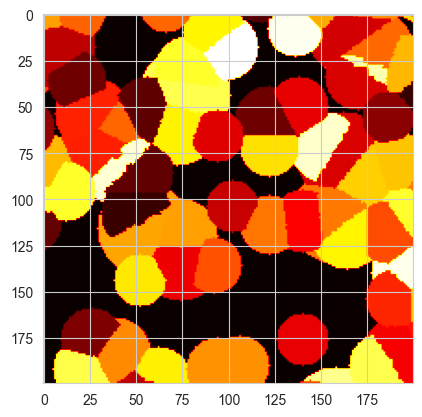

In [19]:
x, y, s_x, s_y = 4000, 6100, 200, 200
plt.imshow(img_seg[x:x+s_x, y:y+s_y], cmap='hot')

In [22]:
%%time
direction = [[1, 0], [0, 1], [-1, 0], [0, -1]]
direction1 = [[1, 0], [0, 1], [-1, 0], [0, -1], [2, 0], [0, 2], [-2, 0], [0, -2], [1, 1], [-1, 1], [-1, -1], [1, -1]]
img_cell_boundaries = np.zeros((img_seg.shape[0], img_seg.shape[1], 3))
for i in nuclei_pixel_dict.keys():
    nuclei_pixel_temp = nuclei_pixel_dict[i]
    x0, y0 = nuclei_pixel_temp[0]
    idx = img_seg[x0, y0]
    for x, y in nuclei_pixel_temp:
        for k in range(4):
            x1, y1 = x+direction[k][0], y+direction[k][1]
            if 0<=x1<=img_seg.shape[0]-1 and 0<=y1<=img_seg.shape[1]-1:
                if img_seg[x1,y1] != idx:
                    img_cell_boundaries[x, y] = [150, 150, 150]
                    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


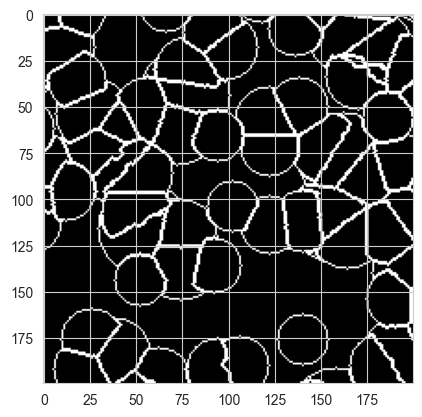

In [24]:
x, y, s_x, s_y = 4000, 6100, 200, 200
plt.imshow(img_cell_boundaries[x:x+s_x, y:y+s_y], cmap='hot')

In [23]:
cv.imwrite(results_folder+'cell_boundries.png', img_cell_boundaries)
np.save(results_folder+'cell_boundries.npy', img_cell_boundaries)

In [28]:
img_seg_orig = np.load(results_folder+'segmentation_label.npy')
img_seg_boundries = img_cell_boundaries.copy()
img_seg_boundries[img_seg_orig>0] = [0, 255, 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


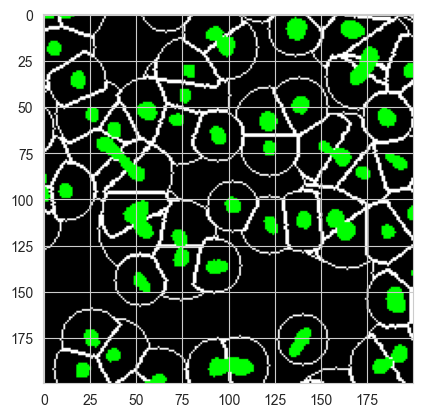

In [29]:
plt.imshow(img_seg_boundries[x:x+s_x, y:y+s_y], cmap='hot')

In [30]:
cv.imwrite(results_folder+'seg+boundries.png', img_seg_boundries)
np.save(results_folder+'seg+boundries.npy', img_seg_boundries)

In [6]:
img_seg_boundries = np.load(results_folder+'seg+boundries.npy')

In [7]:
for i in range(len(adata_st)):
    img_seg_boundries = cv.circle(img_seg_boundries, adata_st.obsm['spatial'][i], 73//2, (0, 0, 255), 3)

In [8]:
cv.imwrite(results_folder+'seg+boundries+spot.png', img_seg_boundries)

True